In [409]:
import pandas as pd 
import datetime
import numpy as np 
import matplotlib.pyplot as plt 
import statsmodels.api as sm
from pylab import rcParams
import warnings
from scipy import stats
from pandas.core.nanops import nanmean as pd_nanmean
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sklearn.metrics import mean_absolute_error

warnings.filterwarnings('ignore')
%matplotlib inline

# Первичный анализ данных
Датасет ежечасной аренды велосипедов в Лондоне с 2015 по 2017 год. 
Содержет в себе информацию о:
1. Количестве арендованных велосипедов
2. Типе дня недели(выходной, празник)
3. Погоде(темература, скорость ветра, сезон, погодные условия)

столбик погодные условия имеет следующие значения:

1 = Clear ; mostly clear but have some values with haze/fog/patches of fog/ fog in vicinity

2 = scattered clouds / few clouds

3 = Broken clouds

4 = Cloudy

7 = Rain/ light Rain shower/ Light rain

10 = rain with thunderstorm

26 = snowfall

94 = Freezing Fog

столбик сезон имеет следующие значения:
0-spring ; 1-summer; 2-fall; 3-winter.

Остальные значения интуитивно понятны, поэтому я не буду подробно на них останавливаться.

Ниже приведена таблица с информацией о всех признаках данного датасета и типах переменных

In [410]:
bike_sharing = pd.read_csv('london_merged.csv',  sep=',', comment='#')
print(bike_sharing.dtypes)
bike_sharing.head()

timestamp        object
cnt               int64
t1              float64
t2              float64
hum             float64
wind_speed      float64
weather_code    float64
is_holiday      float64
is_weekend      float64
season          float64
dtype: object


,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


# Предобработка данных

Отсортируем датасет по времени. Индексы заменим на соответствующий врменной пероид и удалим столбик timestamp.


In [411]:
bike_sharing.sort_values('timestamp',axis = 0,inplace =True)
bike_sharing['timestamp'] = pd.to_datetime(bike_sharing.timestamp, format='%Y-%m-%d %H:%M:%S')
bike_sharing = bike_sharing.iloc[:-23]
bike_sharing.index  = bike_sharing.timestamp
bike_sharing.drop('timestamp',  axis = 1, inplace = True)
bike_sharing.head(2)

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
timestamp,,,,,,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0


# Визуальный анализ данных


Для начала построим график зависимости количества арендованных велочипедов от даты

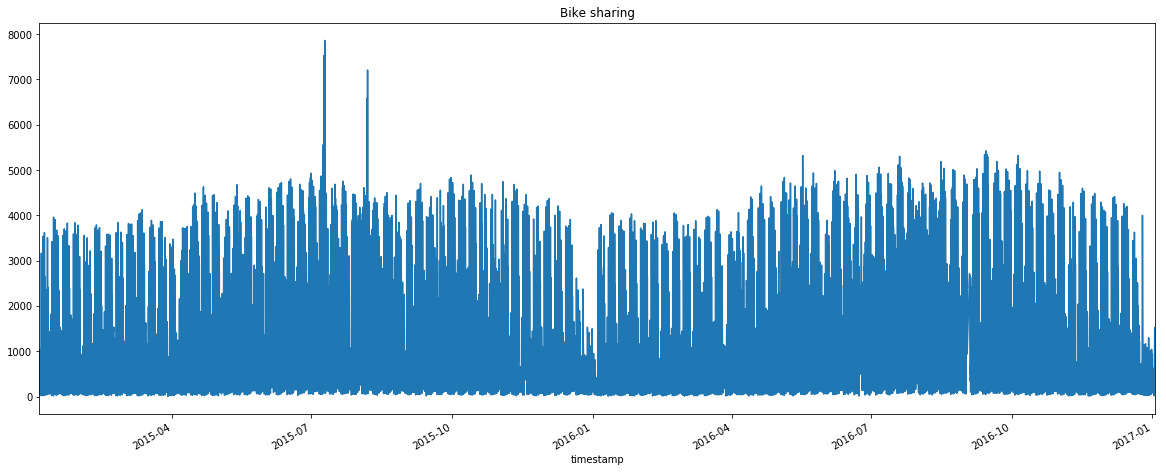

In [412]:
bike_sharing.cnt.plot(figsize=(20, 8), title='Bike sharing')

Проанализировав график, можно заметить, что набдлюдается спад в зимние месяцы.
На мой взгляд, это связано с неблпгоприятными погодными услвиями для катания:
холод, дождь/снег.    

Давайте проверим это. Нарисуем еще несколько графиков:
    1-2. Зависимость спроса на велосипеды от выходного/праздника
    3. Зависимость спроса от сезона
    4. Зависимость спроса от погодных условий

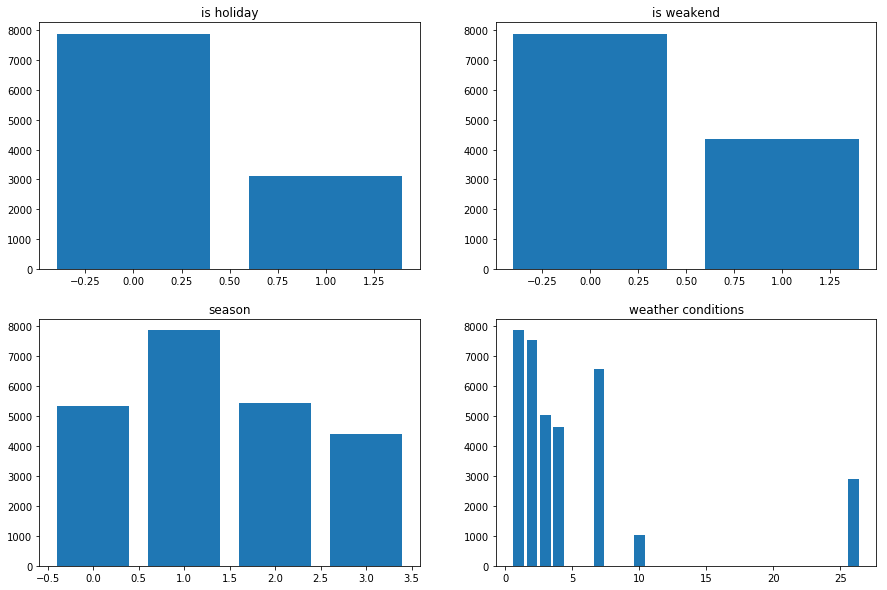

In [413]:
fig, axes = plt.subplots(2, 2, sharey=False, sharex=False)
fig.set_figwidth(15)
fig.set_figheight(10)

axes[0][0].bar(bike_sharing.is_holiday, bike_sharing.cnt)
axes[0][0].set_title("is holiday")

axes[0][1].bar(bike_sharing.is_weekend, bike_sharing.cnt)
axes[0][1].set_title("is weakend")

axes[1][0].bar(bike_sharing.season, bike_sharing.cnt)
axes[1][0].set_title("season")

axes[1][1].bar(bike_sharing.weather_code, bike_sharing.cnt)
axes[1][1].set_title("weather conditions")

plt.show()

Видим, что спрос на велосипеды значительно выше в праздники и выходные.
Также летом прокатом пользуются более интенсивно, чем в отсальные сезоны.
Как можно видеть по графику номер 4, в ясную или туманную погоду спрос высокий
(столбикик 1-4). Также во время легкого дождя неожиданно много людей катается на велосипедах(
(столбик 5). Во время грозы и при снегопаде спрос нулевой. Таким образом, можно сделать 
вывод, что погодные условия влияют на прокат велосипедов.


#### Декомпозиция временного ряда

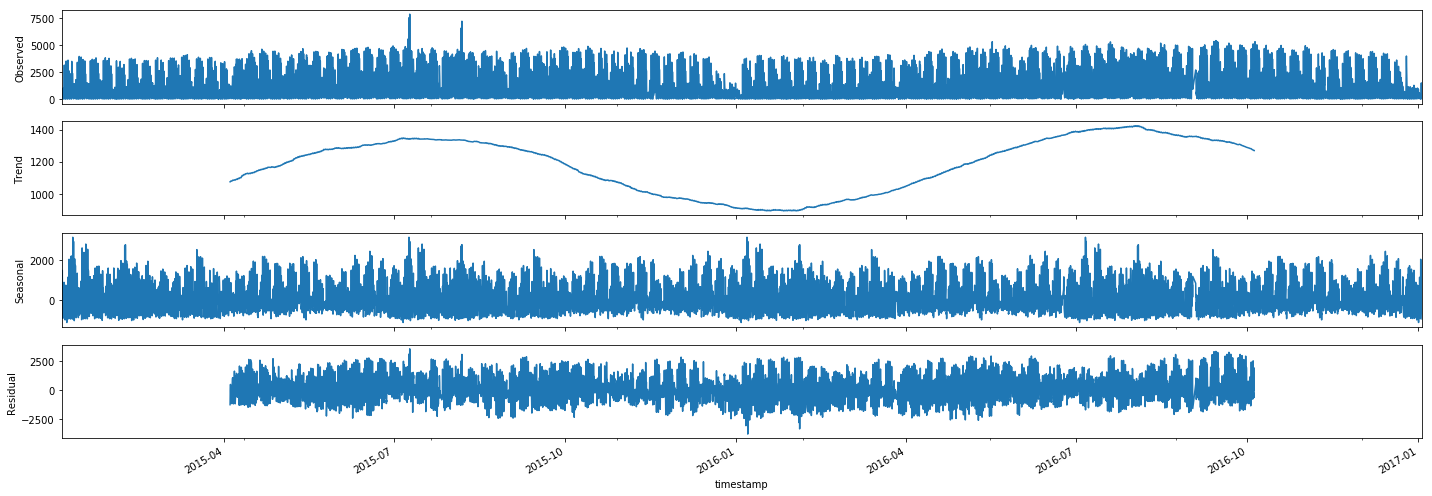

In [414]:
rcParams['figure.figsize'] = 20, 7
result = sm.tsa.seasonal_decompose(bike_sharing.cnt, model='additive',freq= 24*30*6)
result.plot()
plt.show()

#### Рассмотрим отдельно тренд сезонность и выбросы

Как и следовало ожидать, тренд возрастест в весенне-летние сезоны и падает к земе.

А теперь сдлеаем декомпозицию на более узком промежутке времени. К примеру возьмем обычную летнюю неделю.

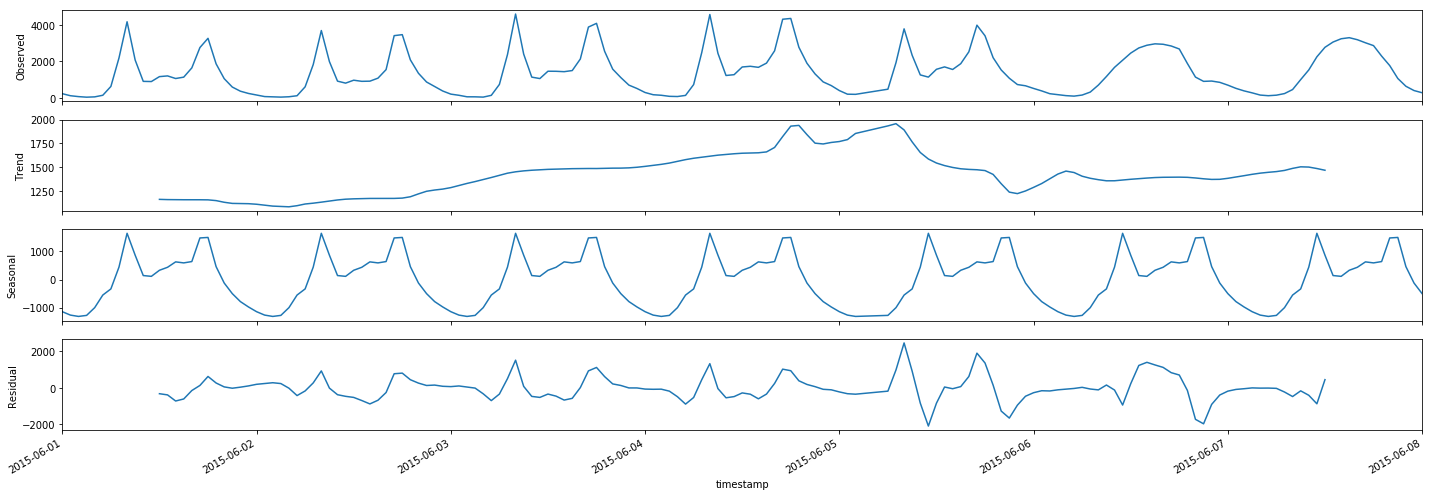

In [415]:
rcParams['figure.figsize'] = 20, 7
sh = bike_sharing['2015-06-01 00:00:00': '2015-06-08 00:00:00']
result = sm.tsa.seasonal_decompose(sh.cnt, model='additive',freq= 24)
result.plot()
plt.show()

Видим, что в выходные график более гладкий. Это может означать, что в будние дни люди используют велосипед, чтобы доехать на работу и 
домой. Мы видим острые пики в утренние часы и вечерние. Днем спрос в будни резко падает. 

В выхдные наблюдается плавное увелечение спроса в первой половине дня, затем такой же плавный спад во второй. 

#### Еще одно интересное замечание


В датасете есть несколько выбросов. 2015-07-09, 2015-07-09 и 2015-08-06
Спрос на велосипеды в эти дни был значительно выше. По данным из новостей за 2015 в эти дни были
забастовки работниокв метро, и оно не работало.


In [416]:
sh = bike_sharing[bike_sharing.cnt > 7000]
sh

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
timestamp,,,,,,,,,
2015-07-09 08:00:00,7531,14.5,14.5,61.0,19.0,2.0,0.0,0.0,1.0
2015-07-09 17:00:00,7860,23.0,22.0,27.0,11.0,1.0,0.0,0.0,1.0
2015-08-06 17:00:00,7208,22.5,22.5,55.0,17.5,2.0,0.0,0.0,1.0


# Предсказание временного ряда

Предскажем количество арендованных велосипедов на неделю вперед

In [417]:
train = bike_sharing.cnt.iloc[:-24*7]
test = bike_sharing.cnt.iloc[-24*7:]

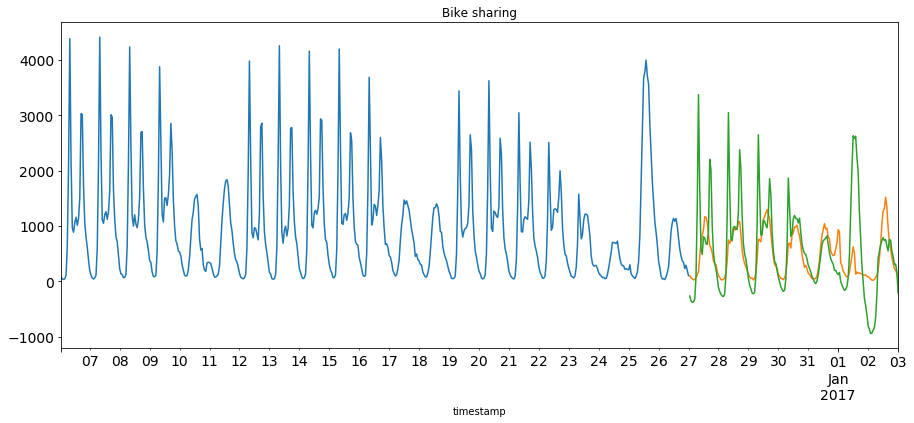

In [418]:
train.iloc[-504:].plot(figsize=(15, 6), title='Bike sharing', fontsize=14)
test.plot(figsize=(15, 6), title='Bike sharing', fontsize=14)
forecast= test.copy()

fit1 = ExponentialSmoothing(np.asarray(train), 
                            seasonal_periods=24*7,
                            seasonal='add').fit()

forecast = pd.Series(fit1.forecast(len(test)))
forecast.index = test.index
forecast.plot(figsize=(15, 6), title='Bike sharing', fontsize=14)

 #### найдем ошибку

In [419]:
from sklearn.metrics import  mean_squared_error
mean_squared_error(test, forecast)

465932.71261453326

#### Построим модель SARIMA для предсказания на временном ряду

Проверим ряд на стационарность

In [420]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries, window=24, cutoff=0.05):
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()
    
    fig = plt.figure(figsize=(12, 8))
    origin = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='rolling mean')
    plt.legend(loc='best')
    plt.title('Rolling mean and Standard deviation')
    plt.show()
    
    std = plt.plot(rolstd, color='black', label='Rolling std')
    plt.show()
    
    print('Result of Dickey-Fuller Test:')
    dftest = adfuller(timeseries.values, autolag='AIC')
    dfoutput = pd.Series(dftest[:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key, val in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = val
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
        
    print(dfoutput)
        

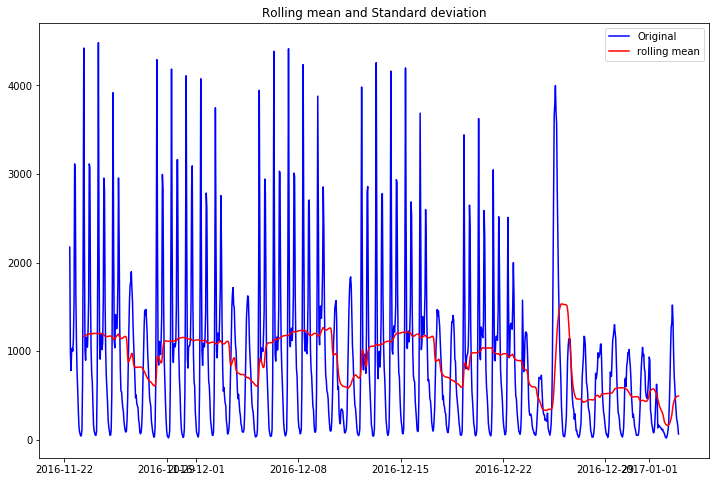

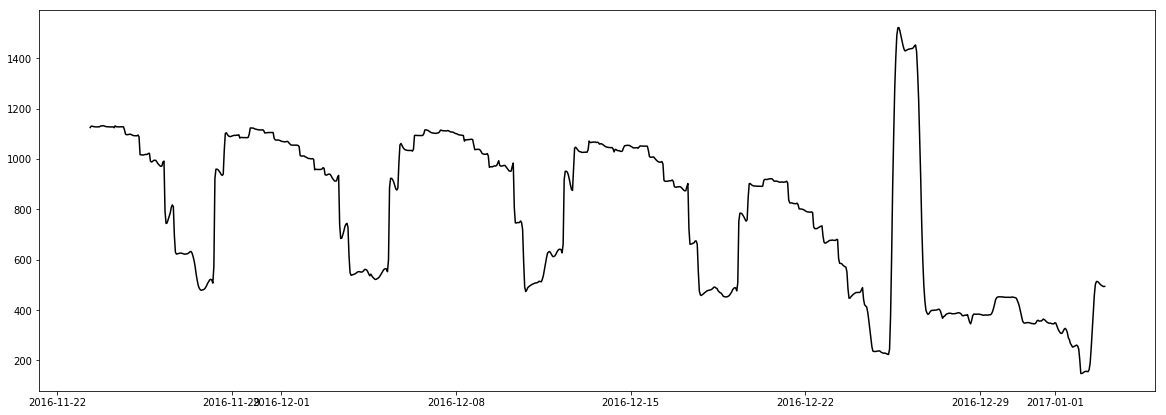

Result of Dickey-Fuller Test:
p-value = 0.1439. The series is likely non-stationary.
Test Statistic                  -2.392521
p-value                          0.143858
#Lags Used                      22.000000
Number of Observations Used    977.000000
Critical Value (1%)             -3.437061
Critical Value (5%)             -2.864503
Critical Value (10%)            -2.568348
dtype: float64


In [421]:
sample = bike_sharing.cnt[-1000:]
test_stationarity(sample)

Временной ряд не стационарен

модель SARIMA определяется 6-ю параметрами
- p, P - порядок компоненты AR
- q, Q - порядок компоненты MA
- d, D - порядок интегрированного ряда

#### Интегрирование

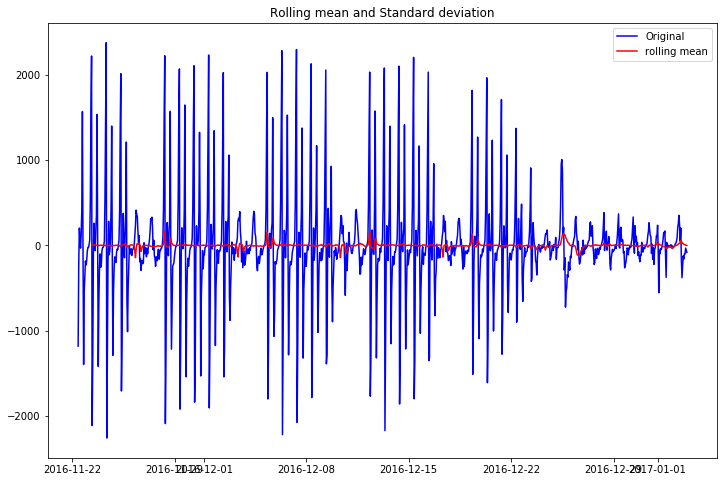

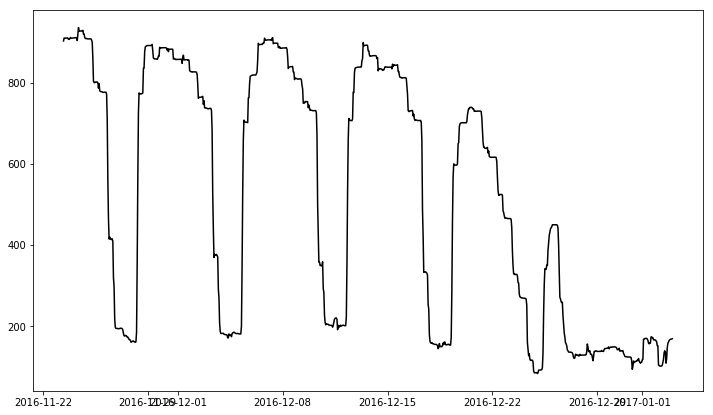

Result of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                 -22.066829
p-value                          0.000000
#Lags Used                      22.000000
Number of Observations Used    976.000000
Critical Value (1%)             -3.437068
Critical Value (5%)             -2.864506
Critical Value (10%)            -2.568349
dtype: float64


In [422]:
rcParams['figure.figsize'] = 12, 7
sample_diff = sample - sample.shift(1)
sample_diff.dropna(inplace=True)
test_stationarity(sample_diff)

#### d = 1, D = 0

#### Авторегрессия

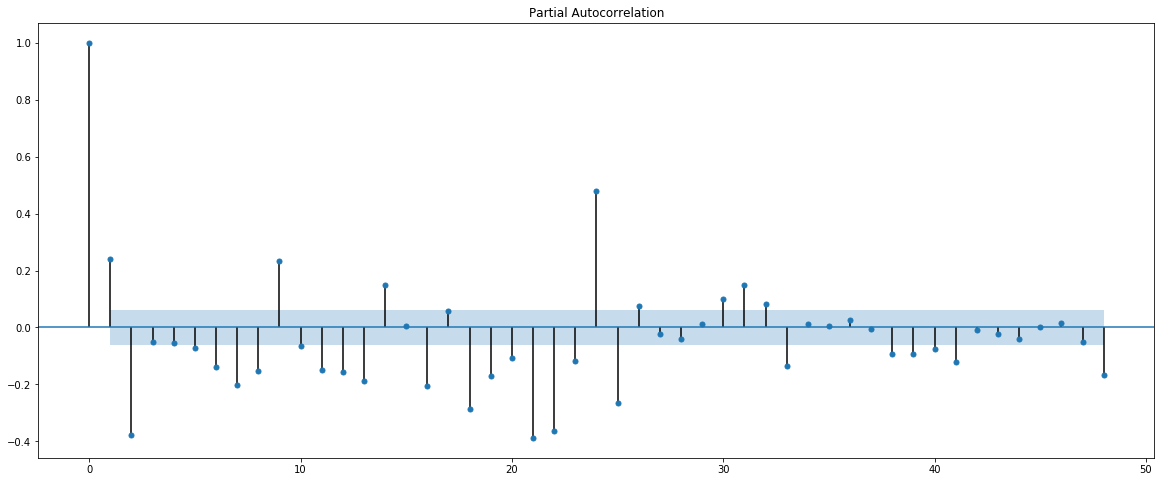

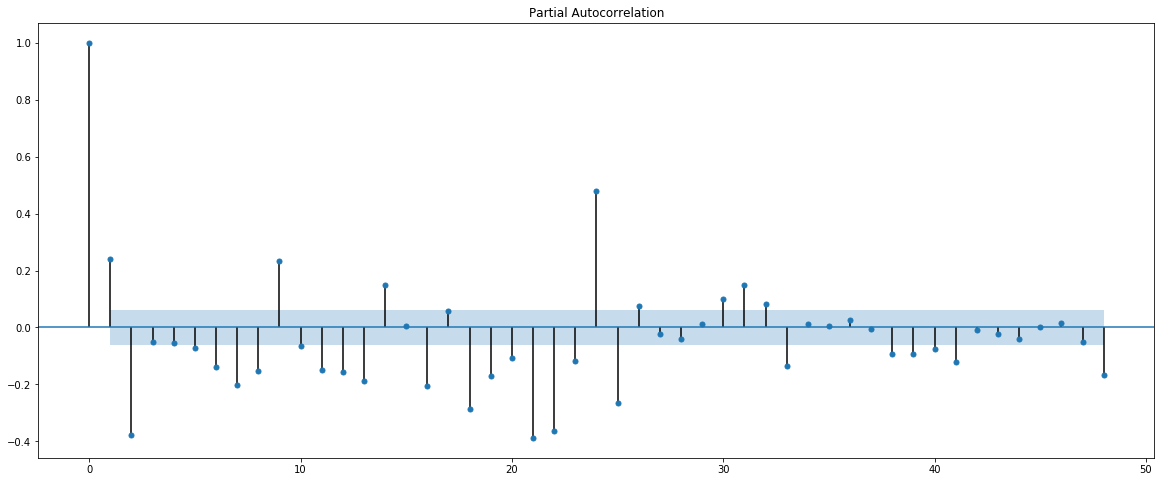

In [423]:
import statsmodels.api as sm

_, ax = plt.subplots(figsize=(20, 8))
sm.graphics.tsa.plot_pacf(sample_diff.values, lags=48, ax=ax)

#### Скользящее среднее (MA - компонент)

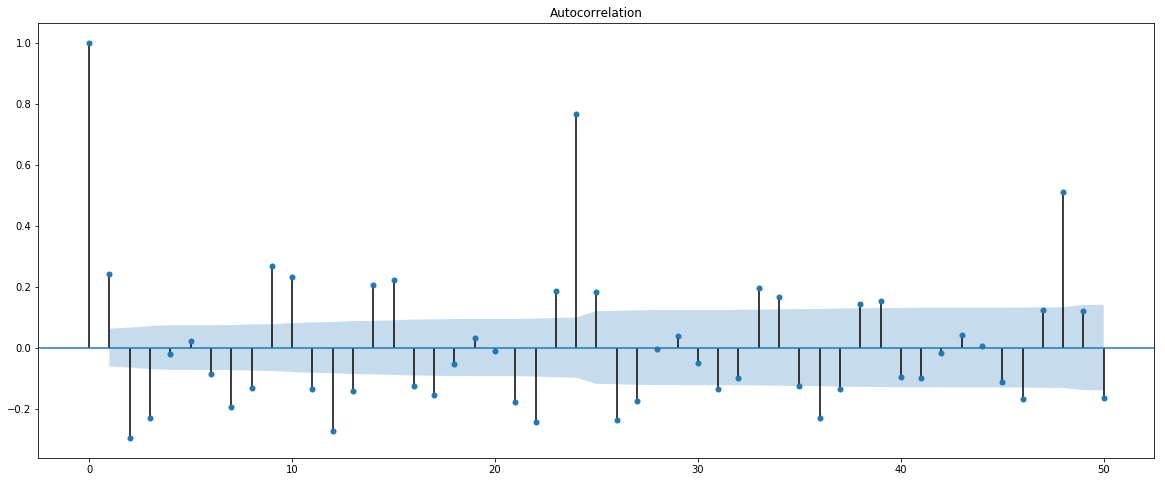

In [424]:
import statsmodels.api as sm
fig, ax = plt.subplots(figsize=(20,8))
sm.graphics.tsa.plot_acf(sample_diff.values, lags=50,ax = ax)
plt.show()

#### Построение прогноза

In [425]:
d = 1
D = 0
s = 24

ps = range(0, 2)   #1, 24
d=1
qs = range(0, 2) #1
Ps = range(0, 2) #1
D=0
Qs = range(0, 2) #2

In [426]:
from itertools import product

paramm = product(ps, qs, Ps, Qs)
param_list = list(paramm)
len(param_list)

16

In [427]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in param_list:
    try:
        model=sm.tsa.statespace.SARIMAX(sample, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 24)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_m = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')
print(best_m.summary().tables[0])
print(best_m.summary().tables[1])


                                 Statespace Model Results                                 
Dep. Variable:                                cnt   No. Observations:                 1000
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 24)   Log Likelihood               -7215.220
Date:                            Sun, 01 Dec 2019   AIC                          14440.441
Time:                                    17:58:46   BIC                          14464.974
Sample:                                11-22-2016   HQIC                         14449.766
                                     - 01-03-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1387      0.062     -2.220      0.026      -0.261      -0.016
ma.L1          0.5272      0.067   

#### Посмотрим на отсатки модели

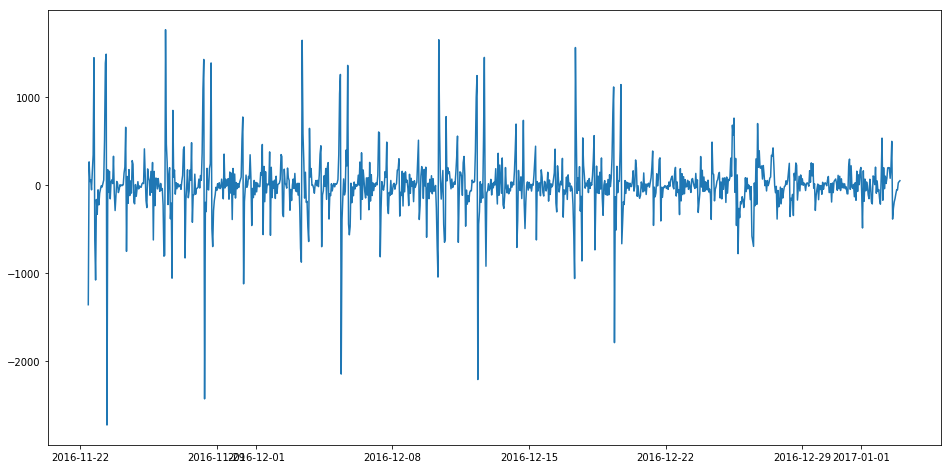

In [428]:
plt.figure(figsize=(16, 8))
plt.plot(best_m.resid[1:])

In [429]:
stat_test = sm.tsa.adfuller(best_m.resid[:])
print ('adf: ', stat_test[0] )
print ('p-value: ', stat_test[1])
print('Critical values: ', stat_test[4])
if stat_test[0]> stat_test[4]['5%']: 
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')

adf:  -12.311109772922148
p-value:  7.08850954750927e-23
Critical values:  {'1%': -3.4369927443074353, '5%': -2.864472756705845, '10%': -2.568331546097238}
единичных корней нет, ряд стационарен


#### Построим прогноз на день вперед

/Users/sonyaserebryakova/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


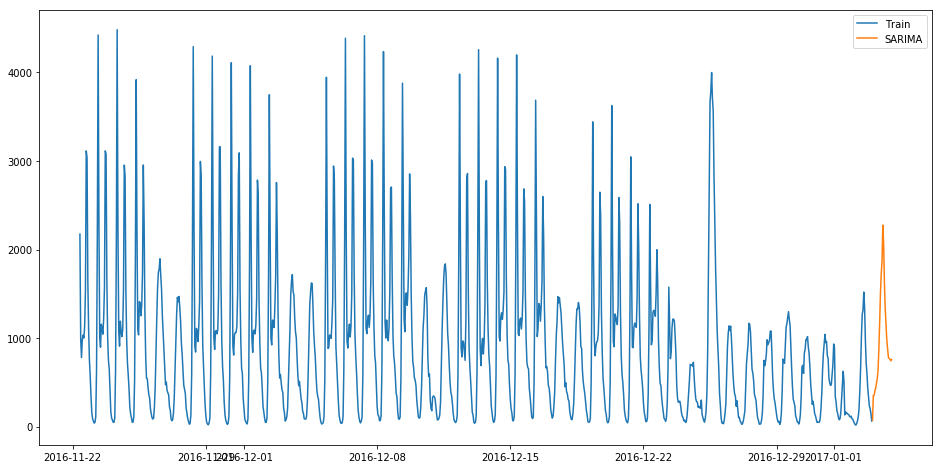

In [430]:
forecast = best_m.predict(start=sample.shape[0], end=sample.shape[0] +24)
plt.figure(figsize=(16,8))
plt.plot(sample, label='Train')
plt.plot(forecast, label='SARIMA')
plt.legend(loc='best')
plt.show()

### Проверка статистических гипотез

#### Z - критерий для доли

Возьмем две подвыборки из исходного датасета 
-  будни 8:00
-  будни 18:00

Такой выбор времени обусловлен тем, что по данным в интернете рабочий день в Лондоне начинается в 8:30, а заканчиватется в 17:30. Кроме того, как мы уже видели ранее, пики активности приходятся именно на выбранное время. Это связано с тем, что люди в это время едут на работу/ с работы на велосипеде.
Сотавим таблицу, в которой еденица ставится если спрос больше 2000
в противном случае 0

In [431]:
from datetime import date

tab = bike_sharing[bike_sharing.index.dayofweek < 5]
tab = tab[tab.index.hour == 8]
tab
tab.loc[tab.cnt > 2000, 'cnt'] = 1  
tab.loc[tab.cnt != 1, 'cnt'] = 0

In [432]:
tab.groupby('cnt').size()

cnt
0     34
1    483
dtype: int64

In [433]:
tab2 = bike_sharing[bike_sharing.index.dayofweek < 5]
tab2 = tab2[tab2.index.hour == 18]
tab2.loc[tab2.cnt > 2000, 'cnt'] = 1  
tab2.loc[tab2.cnt != 1, 'cnt'] = 0 

In [434]:
tab2.groupby('cnt').size()

cnt
0     63
1    455
dtype: int64

проверим гипотезу  H0 - спрос на велосипеды в будни утром и вечером одинаковый, 2000 велосипедов в час
альтернативня гипотеза Н1 - спрос на велосипеды вечером упал(после работы люди устали, нет сил ехать на велосипеде)



In [435]:
def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    
    if alternative == 'two-sided':
        return z_stat,2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return z_stat,scipy.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return z_stat, 1 - scipy.stats.norm.cdf(z_stat)

In [436]:
def proportions_diff_z_stat_rel(sample1, sample2):
    sample = zip(sample1, sample2)
    n = len(sample1)
    
    f = sum([1 if (x[0] == 1 and x[1] == 0) else 0 for x in sample])
    g = sum([1 if (x[0] == 0 and x[1] == 1) else 0 for x in sample])
    
    return float(f - g) / np.sqrt(f + g - float((f - g)**2) / n )

In [437]:
import scipy
proportions_diff_z_test(proportions_diff_z_stat_rel(tab.cnt, tab2.cnt),'less' )



(6.584398050992994, 0.9999999999771634)

p > 0.05 гипотеза H0 принимается

## непараметрические критерии

#### критерий знаков

проверим гипотезу, что летом 2015 года количество арендованных велосипедов в час было 1200

In [439]:
ss = bike_sharing[bike_sharing.index.year == 2015]
ss = ss[ss.index.month > 5]
ss = ss[ss.index.month < 9]

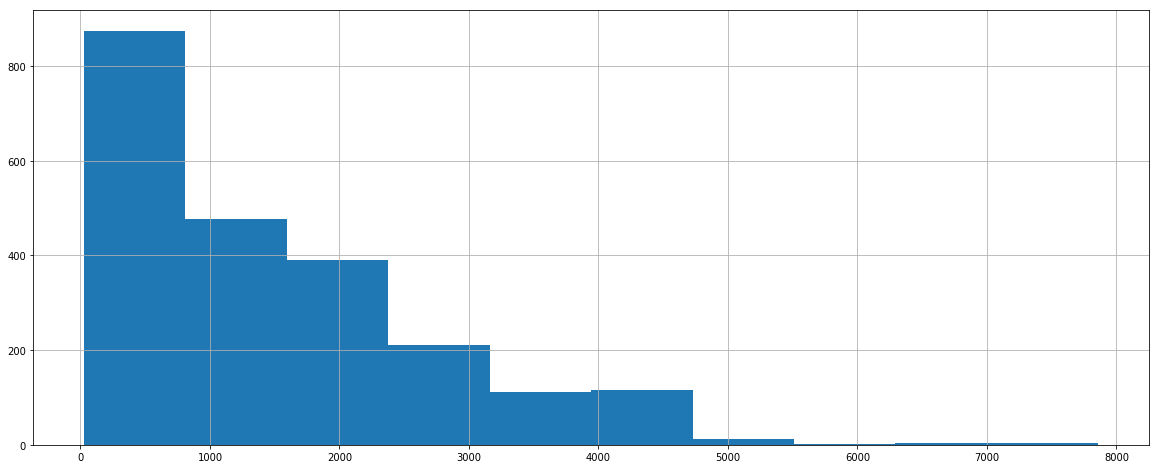

In [440]:
ss.cnt.hist(figsize=(20, 8))

In [441]:
from statsmodels.stats.descriptivestats import sign_test
sign_test(ss.cnt, 1200)

(-1.0, 0.9829909769626295)

p > 0.05 Н0 принимается

### Выводы


Я провела исследование датасета "bike sharing in London". Я изучила признаки и типы переменных в датасете. Выполнила необходимую агрегацию данных. Затем был проведен визуальный анализ данных. Использованы различные типы граффиков. Также показана зависимость спроса от различных параметров: типа дня(праздник/ не правздник; выходной/будний), типа погоды, сезона. По данным графикам я установила, что в выходные, праздники, летом, а также при хороших погодных условиях(солнечно/небольшая облачность/слабый дождь) спрос оказался выше. Так же я обнаружила несколько выбросов и установила, что они являлись причиной забастовки работкиов метро. Провела декомпозицию временного ряда. Рассмотрела тренд и сезонную составляющую по отдельности на различных временных отрезках. 

Так же я проверила две стат. гипотезы: 
- спрос в 8:00 утра и в 18:00 в будни одинаковый, 2000 велосипедов в час
- летом 2015 года количество арендованных велосипедов в час составило 1200 штук
Обе оказались верны

Затем я построила предсказание временного ряда двумя способами:
- Тройное экспоненциальное сглаживаине
- При помощи модели SARIMA